In [2]:
import numpy as np
import glob, os
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from metpy.interpolate import interpolate_1d

In [3]:
datadir = '/pscratch/sd/s/smhagos/HVMIXINGSC/SIMULATIONS/CONTROLRUN/RAW/'
datafile = f'{datadir}wrfout_d01_2014-04-03_20:00:00'

In [4]:
ds = xr.open_dataset(datafile)
ds

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 949, west_east: 1449,
                            bottom_top: 59, bottom_top_stag: 60,
                            soil_layers_stag: 4, west_east_stag: 1450,
                            south_north_stag: 950)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/202)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/129)
    TITLE:                            OUTPUT FROM WRF V4.0 MODEL
    START_DATE:                      2014-04-01_00:00:00
    SIMULATION_START_DATE:           2014-04-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1450
    SOUTH-NORTH_GRID_DIMENSION:      950
    BOTTOM-TOP_GRID_DIMENSION:       60
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [6]:
# 3D height
Z3D = (ds['PHB'] + ds['PH']).squeeze() / 9.80665
# Get center point height (destagger)
Z3D_ds = (Z3D.data[:-1,:,:] + Z3D.data[1:,:,:]) / 2
# 3D variable
REFL_10CM = ds['REFL_10CM'].squeeze()

In [19]:
Z3D_ds.shape, REFL_10CM.shape

((59, 949, 1449), (59, 949, 1449))

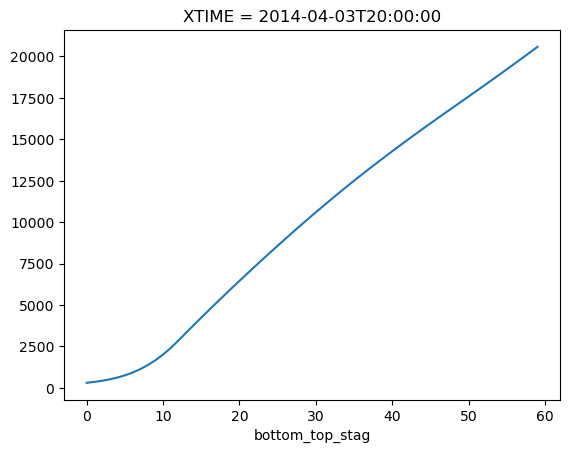

In [8]:
Z3D.mean(dim=('south_north','west_east')).plot()

In [24]:
HAMSL = np.arange(1000.0, 20000.1, 1000)
REFL_reg = interpolate_1d(HAMSL, Z3D_ds, REFL_10CM.data, axis=0, fill_value=np.NaN)

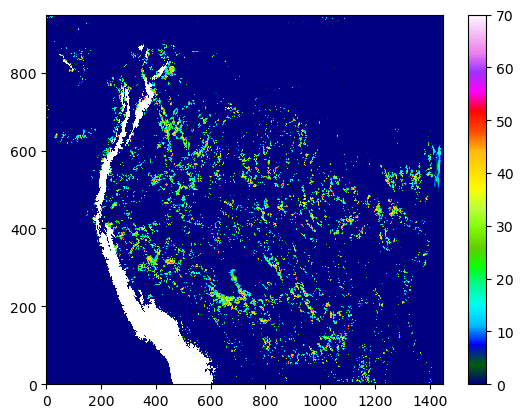

In [31]:
Zm = np.ma.masked_invalid(REFL_reg[1,:,:])
plt.pcolormesh(Zm, vmin=0, vmax=70, cmap='gist_ncar')
plt.colorbar()

In [ ]:
def interpolate_forcing_era5(zout, z, w, u, v, ta, ma, ug, vg, zs):
    """
    interpolate all the forcing profiles to SAM's vertical grid given by `zout`
    """

    nt, nz, ny, nx = z.shape
    zi = np.zeros((nt, nz + 1, ny, nx))
    """
    This is just one way to take into account surface elevation.
    The other way is to interpolate using z (heights above MSL) directly,
    then add a mean surface elevation to zout. Using the latter method, the averaging
    will be done on heights above MSL rather than heights above surface.
    But given the small surface elevations we have around ENA, it shouldn't make much difference. 
    """
    zi[:, :-1, :, :] = z.values - zs.values[:, np.newaxis, :, :]
    # zi[:, :-1, :, :] = z.values
    # zout = zout + zs.values.mean()
    out = []
    sfc = [0, 0, 0, 1, 1, 1, 1]
    for v, s in zip([w, u, v, ta, ma, ug, vg], sfc):
        vi = np.zeros_like(zi)
        vi[:, :-1, :, :] = v.values
        # surface winds are all zero
        if s == 1:
            vi[:, -1, :, :] = v.values[:, -1, :, :]
        # vi[:, -1, :, :] = v.values[:, -1, :, :]
        vo = interpolate_1d(zout, zi, vi, axis=1)
        out.append(vo.mean(axis=(2, 3)))
    return out